In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tfrecorder import TFrecorder
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


# data

In [2]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


# how to write

In [3]:
# info of data
df = pd.DataFrame({'name':['image','label','image_shape'],
                  'type':['float32','int64','int64'],
                  'shape':[(784,),(),(3,)],
                  'isbyte':[False,False,False],
                  "length_type":['var','fixed','fixed'],
                  "default":[np.NaN,np.NaN,np.NaN]})
'''
Note:
1. if the shape of particular feature for every example in your dataset varies, then you must set "length_type" as 'var'
     example: 'image' feature for the first example is 28x28; but for the second example is 64x64
2. 'image_shape' decides the final shape of 'image'
     example: the shape of 'image' is 784 when you write the tfrecord file, but the final shape after parsing is reshaped by the value of 'image_shape'
3. by default, '_shape' info will not be returned after parsing, 
   if you want to keep '_shape' info, please use: tfr = TFrecorder(retrieve_shape=True)
'''

'\nNote:\n1. if the shape of particular feature for every example in your dataset varies, then you must set "length_type" as \'var\'\n     example: \'image\' feature for the first example is 28x28; but for the second example is 64x64\n2. \'image_shape\' decides the final shape of \'image\'\n     example: the shape of \'image\' is 784 when you write the tfrecord file, but the final shape after parsing is reshaped by the value of \'image_shape\'\n3. by default, \'_shape\' info will not be returned after parsing, \n   if you want to keep \'_shape\' info, please use: tfr = TFrecorder(retrieve_shape=True)\n'

In [4]:
df

,default,isbyte,length_type,name,shape,type
0,NaN,False,var,image,"(784,)",float32
1,NaN,False,fixed,label,(),int64
2,NaN,False,fixed,image_shape,"(3,)",int64


# write

In [5]:
tfr = TFrecorder()

In [6]:
rm -rf mnist_tfrecord/train mnist_tfrecord/test

In [7]:
mkdir -p mnist_tfrecord/train mnist_tfrecord/test

In [8]:
dataset = mnist.train
path = 'mnist_tfrecord/train/train'
num_examples_per_file = 10000
num_so_far = 0

writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
print('saved %s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
# write mutilple examples
for i in np.arange(dataset.num_examples):
    features = {}
    # write image of one example
    tfr.feature_writer(df.iloc[0], dataset.images[i], features)
    # write label of one example
    tfr.feature_writer(df.iloc[1], dataset.labels[i], features)
    # ******************
    # write shape info *
    # ******************
    tfr.feature_writer(df.iloc[2], dataset.images[i].reshape((28,28,1)).shape, features)
    
    tf_features = tf.train.Features(feature= features)
    tf_example = tf.train.Example(features = tf_features)
    tf_serialized = tf_example.SerializeToString()
    writer.write(tf_serialized)
    if i%num_examples_per_file ==0 and i!=0:
        writer.close()
        num_so_far = i
        writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
        print('saved %s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
writer.close()

saved mnist_tfrecord/train/train0_10000.tfrecord
saved mnist_tfrecord/train/train10000_20000.tfrecord
saved mnist_tfrecord/train/train20000_30000.tfrecord
saved mnist_tfrecord/train/train30000_40000.tfrecord
saved mnist_tfrecord/train/train40000_50000.tfrecord
saved mnist_tfrecord/train/train50000_60000.tfrecord


In [9]:
# 用该方法写测试集的tfrecord文件
dataset = mnist.test
path = 'mnist_tfrecord/test/test'
# 每个tfrecord文件写多少个样本
num_examples_per_file = 10000
# 当前写的样本数
num_so_far = 0
# 要写入的文件
writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
print('saved %s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
# 写多个样本
for i in np.arange(dataset.num_examples):
    # 要写到tfrecord文件中的字典
    features = {}
    # 写一个样本的图片信息存到字典features中
    tfr.feature_writer(df.iloc[0], dataset.images[i], features)
    # 写一个样本的标签信息存到字典features中
    tfr.feature_writer(df.iloc[1], dataset.labels[i], features)
    # ******************
    # write shape info *
    # ******************
    tfr.feature_writer(df.iloc[2], dataset.images[i].reshape((28,28,1)).shape, features)
    
    tf_features = tf.train.Features(feature= features)
    tf_example = tf.train.Example(features = tf_features)
    tf_serialized = tf_example.SerializeToString()
    writer.write(tf_serialized)
    # 每写了num_examples_per_file个样本就令生成一个tfrecord文件
    if i%num_examples_per_file ==0 and i!=0:
        writer.close()
        num_so_far = i
        writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
        print('saved %s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
writer.close()
# 把指定如何写成tfrecord文件的信息保存起来
data_info_path = 'mnist_tfrecord/data_info.csv'
df.to_csv(data_info_path,index=False)

saved mnist_tfrecord/test/test0_10000.tfrecord


# import function

In [10]:
tfr = TFrecorder(retrieve_shape=True)
def input_fn_maker(path, data_info_path, shuffle=False, batch_size = 1, epoch = 1, padding = None):
    def input_fn():
        filenames = tfr.get_filenames(path=path, shuffle=shuffle)
        dataset=tfr.get_dataset(paths=filenames, data_info=data_info_path, shuffle = shuffle, 
                            batch_size = batch_size, epoch = epoch, padding =padding)
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
    return input_fn

In [11]:
padding_info = ({'image':[28,28,1],'label':[],'image_shape':[None]})
test_input_fn = input_fn_maker('mnist_tfrecord/test/',  'mnist_tfrecord/data_info.csv',
                               padding = padding_info)
train_input_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', shuffle=True, batch_size = 512,
                               padding = padding_info)
train_eval_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', batch_size = 512,
                               padding = padding_info)
test_inputs = test_input_fn()

read dataframe from mnist_tfrecord/test/test0_10000.tfrecord x 1


(1, 28, 28, 1) [7] [[28 28  1]]


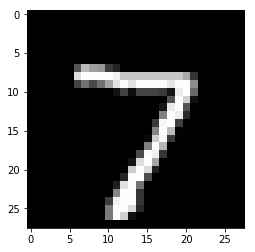

In [12]:
sess =tf.InteractiveSession()
exmaple_image, exmaple_label, exmaple_shape_image = sess.run([test_inputs['image'],test_inputs['label'],test_inputs['image_shape']])
print(exmaple_image.shape, exmaple_label, exmaple_shape_image)
plt.imshow(exmaple_image.reshape((28,28)),cmap=plt.cm.gray)

In [13]:
# Because test_inputs contain n_batch examples, and each example has different image shape.
# executing tf.reshape once can not do the work.
# the 1st example in the batch
reshaped_image_example = tf.reshape(test_inputs['image'][0],test_inputs['image_shape'][0])

(28, 28, 1)


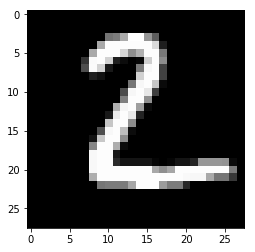

In [14]:
example= sess.run(reshaped_image_example)
print(example.shape)
plt.imshow(example.reshape((28,28)),cmap=plt.cm.gray)